# Self-Driving Car Engineer Nanodegree


## Project: **Advance Lane Detection** 
***



## Import Packages

In [41]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import pickle
%matplotlib inline

## Camera Calibration

In [42]:
# prepare object points
objp = np.zeros((6 * 9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

objpoints = []
imgpoints = []

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find corners on the chessboard and save them to imgpoints
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        cv2.imwrite('camera_cal/corners' + str(idx) + '.jpg', img)
    
    else:
        print("failed to find corners on {}".format(fname))


failed to find corners on camera_cal/calibration1.jpg
failed to find corners on camera_cal/calibration5.jpg
failed to find corners on camera_cal/calibration4.jpg


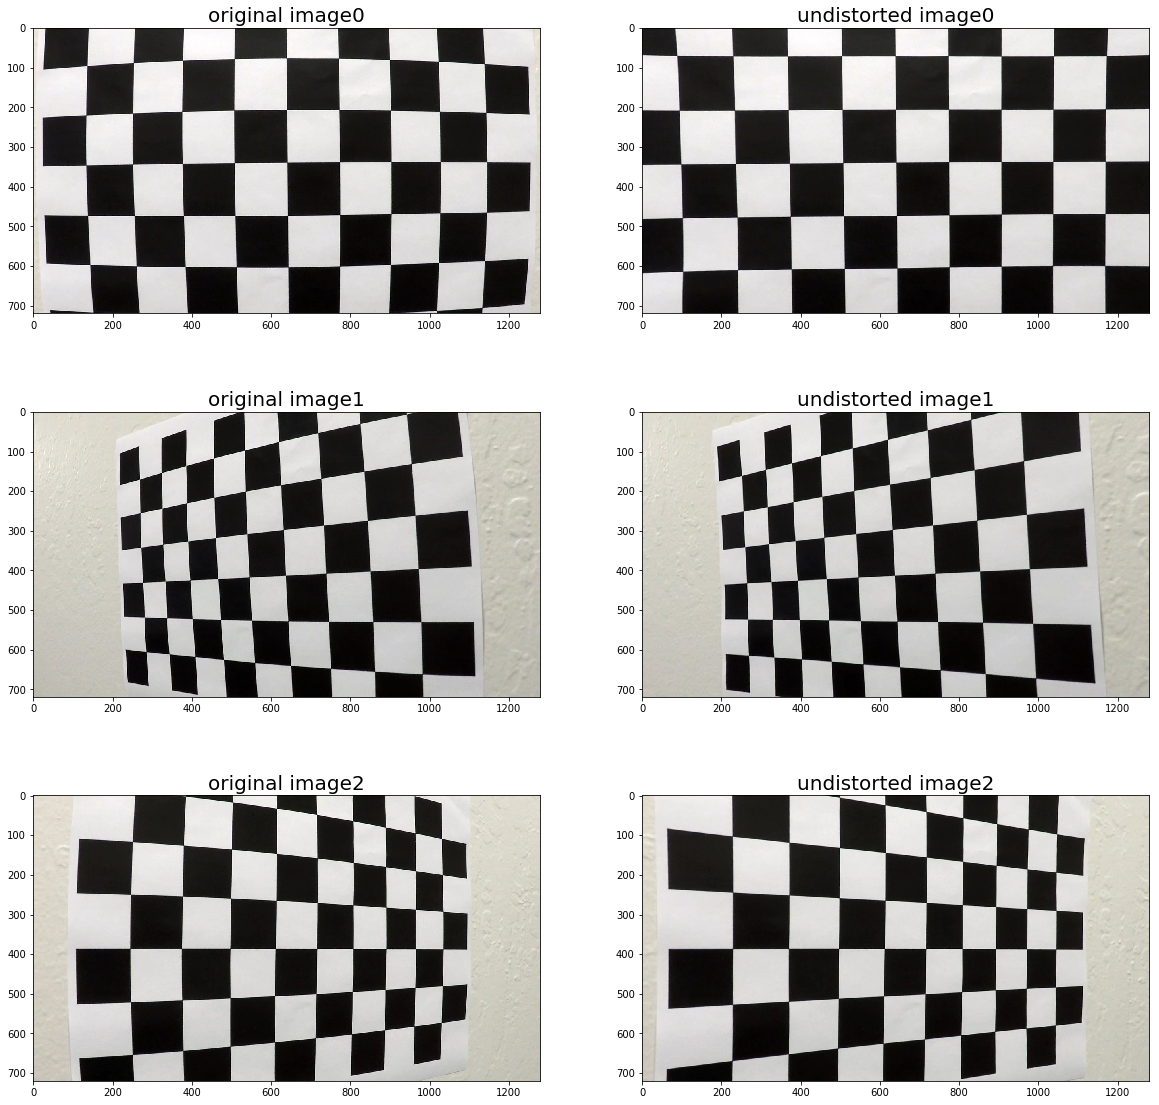

In [43]:
import pickle

# undistort the images whose corners were failed to be found by findChessboardCorners()
test_imgs = ['1', '4', '5']
img_size = (img.shape[1], img.shape[0])

# get the calibrate matrix and coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
for num in test_imgs:
    img = cv2.imread('camera_cal/calibration' + num + '.jpg')
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('camera_cal/undist' + num + '.jpg', dst)

#img = cv2.imread('test_images/straight_lines1.jpg')
#dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('test_images/undist_straight_lines1.jpg', dst)

#img = cv2.imread('test_images/test2.jpg')
#dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('test_images/undist_test2.jpg', dst)
# show the undistorted images

f, ax = plt.subplots(3, 2, figsize = (20, 20))

idx = 0
for num in test_imgs:
    img = cv2.imread('camera_cal/calibration' + num + '.jpg')
    ax[idx][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[idx][0].set_title('original image' + str(idx), fontsize = 20)
    dst = cv2.imread('camera_cal/undist' + num + '.jpg')
    ax[idx][1].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    ax[idx][1].set_title('undistorted image' + str(idx), fontsize = 20)
    idx += 1

# save the result for later use
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open("camera_cal/dist_pickle.p", "wb"))

## Perspective Transform

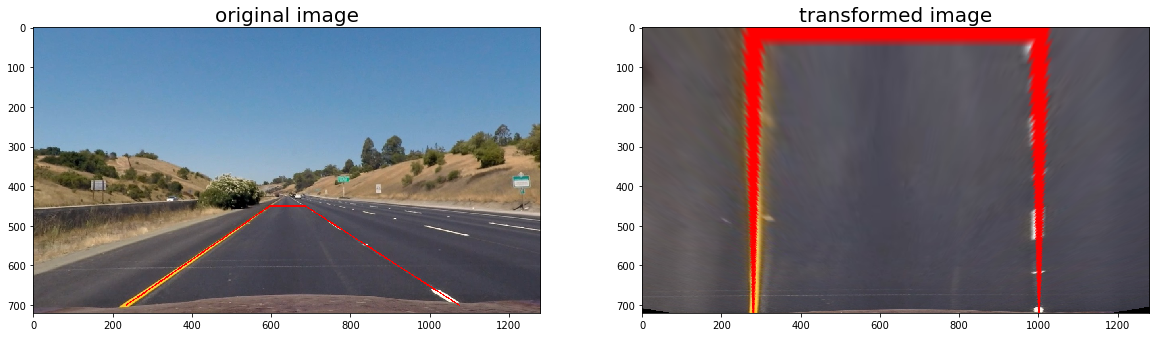

In [44]:
dist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# use the undistorted straight line, and find 4 points
img = cv2.imread("test_images/undist_straight_lines1.jpg")
img_size = (img.shape[1], img.shape[0])

src_p = [(596, 450), (686, 450), (1074, 700), (234, 700)]

# draw lines on the image
cv2.line(img, src_p[0], src_p[1], color = [0, 0, 255], thickness = 2)
cv2.line(img, src_p[1], src_p[2], color = [0, 0, 255], thickness = 2)
cv2.line(img, src_p[3], src_p[0], color = [0, 0, 255], thickness = 2)

src_p = np.float32(src_p)
# define the pointes on the warped image
dst_p = np.float32([[280, 0], [1000, 0], [1000, 720], [280, 720]])

# get the perspective transform matrix and inverse matrix
M = cv2.getPerspectiveTransform(src_p, dst_p)
Minv = cv2.getPerspectiveTransform(dst_p, src_p)

warped = cv2.warpPerspective(img, M, img_size, cv2.INTER_LINEAR)
cv2.imwrite("test_images/undist_straight_lines1_t.jpg", warped)

dist_pickle["M"] = M
dist_pickle["Minv"] = Minv
pickle.dump(dist_pickle, open("camera_cal/dist_pickle.p", "wb"))

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('original image', fontsize = 20)
ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax2.set_title('transformed image', fontsize = 20)


## Helper Functions

In [57]:
def undist(img):
    '''
    function to do the undistortion
    '''
    undist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb"))
    undist_mtx = undist_pickle["mtx"]
    undist_co = undist_pickle["dist"]
    undist_img = cv2.undistort(img, undist_mtx, undist_co, None, undist_mtx)
    return undist_img

def abs_sobel_thresh(img, orient = 'x', krnl = 3, thresh = (0, 255)):
    '''
    function to do the sobel thresholding
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if orient == 'x':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = krnl))
    else:
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = krnl))
    scaled = np.uint8(sobel * 255 / np.max(sobel))
    
    b_img = np.zeros_like(scaled)
    b_img[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    
    return b_img

def hs_thresh(img, s_thresh = (0, 255), h_thresh = (0, 255)):
    '''
    function to do the H and S channel thresholing
    '''
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    h_chan = hls[:,:,0]
    
    b_img = np.zeros_like(s_channel)
    
    if from_video == 0:
        hb_img = np.zeros_like(s_channel)
        hb_img[(h_chan > h_thresh[0]) & (h_chan < h_thresh[1])] = 1  
        plt.figure()
        plt.imshow(hb_img, cmap = 'gray')
        plt.title("h_chan")

    # generate the binary image for h and s channel thresholding  
    b_img[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & 
          (h_chan < h_thresh[1])] = 1
    
    return b_img

def thresholding(img):
    '''
    return the binary image
    '''
    # get the binary image after sobex thresholding on x-dir
    b_sobelx = abs_sobel_thresh(img, 'x', 3, (35, 255))
    # get the binary image after hs channel thresholding
    b_s_chan = hs_thresh(img, (90, 255), (0, 60))

    # combine them together
    b_comb = np.zeros_like(b_s_chan)
    b_comb[(b_sobelx == 1) | (b_s_chan == 1)] = 1
    
    if from_video == 0:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
        ax1.imshow(b_sobelx, cmap = 'gray')
        ax1.set_title('sobelx image', fontsize = 20)
        ax2.imshow(b_s_chan, cmap = 'gray')
        ax2.set_title('s-chan image', fontsize = 20)

    return b_comb

def pers_transform(img):
    '''
    return the perspective-transformed image
    '''
    img_size = (img.shape[1], img.shape[0])
    trans_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb"))
    trans_M = trans_pickle['M']
    t_img = cv2.warpPerspective(img, trans_M, img_size, cv2.INTER_LINEAR)
    return t_img

# continuous bad detection threshold
cont_bad_max = 5
margin = 100
minpix = 50
nwin = 9
# number of frames for smoothing
nsmooth = 5
# threshold of the car off center to treat it as bad
pos_off_thresh = 720/5
# threshold of the lane width detection to treat it as bad
width_diff_thresh = 720/10
xm_per_pix = 3.7/720

# debugging variable to differentiate if we are handling a test image or a 
# video frame
from_video = 0

class lane():
    def __init__(self):
        self.fits = [] # the last several fit coefficents
        self.last_fit = [] # the last fit coefficients
        self.cont_bad = 0 # continuous failures of sanity check
        self.last_rad = 0.0 # last radius calculated
        self.last_off = 0.0 # last distance off center calculated

left = lane()
right = lane()

def sliding_search(b_warped):
    '''
    function to do the sliding window search
    '''
    # get the base points first
    hist = np.sum(b_warped[b_warped.shape[0]//2:, :], axis = 0)
    mid = np.int(hist.shape[0]/2)
    lx_base = np.argmax(hist[:mid])
    rx_base = np.argmax(hist[mid:]) + mid

    win_height = np.int(b_warped.shape[0]/nwin)
    
    # none zeros points in the binary image
    nonzero = b_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    lx_cur = lx_base
    rx_cur = rx_base

    l_inds = []
    r_inds = []
    # go through each window, and find out the non-zero pixels
    for win in range(nwin):
        win_y_low = b_warped.shape[0] - (win + 1) * win_height
        win_y_high = b_warped.shape[0] - win * win_height
        win_xleft_low = lx_cur - margin
        win_xleft_high = lx_cur + margin
        win_xright_low = rx_cur - margin
        win_xright_high = rx_cur + margin

        good_l_inds = ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) &
            (nonzerox > win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_r_inds = ((nonzeroy > win_y_low) & (nonzeroy < win_y_high)
            & (nonzerox > win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        l_inds.append(good_l_inds)
        r_inds.append(good_r_inds)

        if len(good_l_inds) > minpix:
            lx_cur = np.int(np.mean(nonzerox[good_l_inds]))
        if len(good_r_inds) > minpix:
            rx_cur = np.int(np.mean(nonzerox[good_r_inds]))

    l_inds = np.concatenate(l_inds)
    r_inds = np.concatenate(r_inds)

    lx = nonzerox[l_inds]
    ly = nonzeroy[l_inds]
    rx = nonzerox[r_inds]
    ry = nonzeroy[r_inds]
    
    return lx, ly, rx, ry


def find_inds(warped):
    '''
    find out the potential indices of the lane in binary
    images
    '''
    # if we have continous bad detections, do the sliding search again
    if(left.cont_bad >= cont_bad_max or len(left.fits) == 0):
        lx, ly, rx, ry = sliding_search(warped)
        # very very very important
        left.cont_bad = 0 
        left.fits = []
        right.fits = []
    else:    
        # skip sliding window search, find out pixels based on previous fit results
        l_fit = left.last_fit
        r_fit = right.last_fit
    
        nonzero = warped.nonzero()
        nonzeroy = nonzero[0]
        nonzerox = nonzero[1]
    
        l_inds = ((nonzerox > (l_fit[0] * (nonzeroy ** 2) + l_fit[1] * nonzeroy + l_fit[2] - margin)) &
              (nonzerox < (l_fit[0] * (nonzeroy ** 2) + l_fit[1] * nonzeroy + l_fit[2] + margin)))
        r_inds = ((nonzerox > (r_fit[0] * (nonzeroy ** 2) + r_fit[1] * nonzeroy + r_fit[2] - margin)) &
              (nonzerox < (r_fit[0] * (nonzeroy ** 2) + r_fit[1] * nonzeroy + r_fit[2] + margin)))
    
        lx = nonzerox[l_inds]
        ly = nonzeroy[l_inds]
        rx = nonzerox[r_inds]
        ry = nonzeroy[r_inds]
    

    return lx, ly, rx, ry

def fit_poly(lx, ly, rx, ry):
    '''
    fit the polynormial and save the result to last_fit
    '''
    l_fit = np.polyfit(ly, lx, 2)
    r_fit = np.polyfit(ry, rx, 2)
    
    left.last_fit = l_fit
    right.last_fit = r_fit

    return l_fit, r_fit

def sanity_check(img_shape):
    '''
    sanity check the calculation results, this function is not 
    actually being used now
    '''
    l_fit = left.last_fit
    r_fit = right.last_fit

    y_low = img_shape[0] - 1

    lx_low = l_fit[0] * y_low ** 2 + l_fit[1] * y_low + l_fit[2]
    rx_low = r_fit[0] * y_low ** 2 + r_fit[1] * y_low + r_fit[2]    
    lx_high = l_fit[2]
    rx_high = r_fit[2]
    dist_off = abs((lx_low + rx_low - img_shape[1]) / 2)

    dist_low = rx_low - lx_low
    dist_high = rx_high - lx_high

    if from_video == 0:
        if abs(dist_low - dist_high) >= width_diff_thresh:
            print("not parallel {},{}".format(dist_low, dist_high))
        elif abs(dist_off) >= pos_off_thresh:
            print("off lane{}".format(dist_off))
        return
    # if the lane is not parallel or the distance to the center is too big, we think it's a bad
    # detection, otherwise, good
    if abs(dist_low - dist_high) < width_diff_thresh and abs(dist_off) < pos_off_thresh:
        # good result
        left.fits.append(l_fit)
        left.fits = left.fits[-5:]
        right.fits.append(r_fit)    
        right.fits = right.fits[-5:]
        left.cont_bad = right.cont_bad = 0

    else:
        # bad result, don’t update fits
        left.cont_bad += 1
        right.cont_bad += 1
        # not doing anything special here
        #left.last_fit = left.fits[-1]
        #right.last_fit = right.fits[-1]
       
    return

def info_process(img_shape):
    '''
    post process the information got from poly fit
    calculate information like radius, distance to lane center
    '''
    sanity_check(img_shape)

    l_fit = left.last_fit
    r_fit = right.last_fit

    y_eval = img_shape[0] - 1
    # calculate the radius
    l_rad = ((1 + (2 * l_fit[0] * y_eval + l_fit[1]) ** 2) ** 1.5) / np.absolute(2 * l_fit[0])
    r_rad = ((1 + (2 * r_fit[0] * y_eval + r_fit[1]) ** 2) ** 1.5) / np.absolute(2 * r_fit[0])

    lx_eval = l_fit[0] * y_eval ** 2 + l_fit[1] * y_eval + l_fit[2]
    rx_eval = r_fit[0] * y_eval ** 2 + r_fit[1] * y_eval + r_fit[2]
    # distance to the lane center
    dist_off = (lx_eval + rx_eval - img_shape[1]) / 2 * xm_per_pix 

    left.last_rad = l_rad    
    right.last_rad = r_rad
    left.last_off = right.last_off = dist_off
    
    return

def draw_lane(img):
    '''
    mark the detected lane area and transform back to the original image
    '''
    trans_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb"))
    trans_M = trans_pickle['M']
    trans_Minv = trans_pickle['Minv']
    
    lane = np.zeros_like(img)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    
    l_fit = left.last_fit
    r_fit = right.last_fit
    lx_fit = l_fit[0] * ploty**2 + l_fit[1] * ploty + l_fit[2]
    rx_fit = r_fit[0] * ploty**2 + r_fit[1] * ploty + r_fit[2]   
    
    pts_l = np.transpose(np.vstack([lx_fit, ploty]))
    pts_r = np.flipud(np.transpose(np.vstack([rx_fit, ploty])))
    pts = np.vstack([pts_l, pts_r])
    # fill the lane area with green color
    cv2.fillPoly(lane, np.int_([pts]), (0, 255, 0))
    # transform back to the original perspective
    inv_warp = cv2.warpPerspective(lane, trans_Minv, (img.shape[1], img.shape[0]))
    # combine with the original image
    result = cv2.addWeighted(img, 1, inv_warp, 0.3, 0)
    
    text1 = "radius = {}m".format(int(left.last_rad))
    if left.last_off > 0:
        dir = "left"
    else:
        dir = "right"
    text2 = "{:.2f}m ".format(left.last_off) + dir + " of center"
        
    # add text information display
    cv2.putText(result, text1, (300, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 4)
    cv2.putText(result, text2, (250, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 4)
    
    return result


def pipeline(img):
    '''
    image pipeline
    '''
    undist_img = undist(img)
    # if this is a video frame, do the color convertion first
    if from_video == 1:
        undist_img = cv2.cvtColor(undist_img, cv2.COLOR_RGB2BGR)

    # thresholding
    thresh_b = thresholding(undist_img)
    
    # perspective transfrom
    warped = pers_transform(thresh_b)

    if from_video == 0:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
        ax1.imshow(thresh_b, cmap = 'gray')
        ax1.set_title('comb image', fontsize = 20)
        ax2.imshow(warped, cmap = 'gray')
        ax2.set_title('warped image', fontsize = 20)
    
    # find out potention lane line pixels
    lx, ly, rx, ry = find_inds(warped)
    # fit polynomial
    l_fit, r_fit = fit_poly(lx, ly, rx, ry)
    
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    lx_fit = l_fit[0] * ploty**2 + l_fit[1] * ploty + l_fit[2]
    rx_fit = r_fit[0] * ploty**2 + r_fit[1] * ploty + r_fit[2]

    # sanity checking, calculation
    info_process(img.shape)
    
    # image overlay
    lane_img = draw_lane(undist_img)

    if from_video == 0:
        plt.figure()
        plt.imshow(warped, cmap = 'gray')
        plt.plot(lx_fit, ploty, color = 'red')
        plt.plot(rx_fit, ploty, color = 'red')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    if from_video == 1:
        # convert back to RGB for video frames
        lane_img = cv2.cvtColor(lane_img, cv2.COLOR_BGR2RGB)
        
    return lane_img
    

## Testing Images

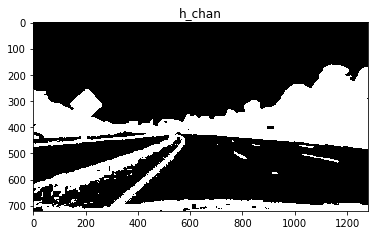

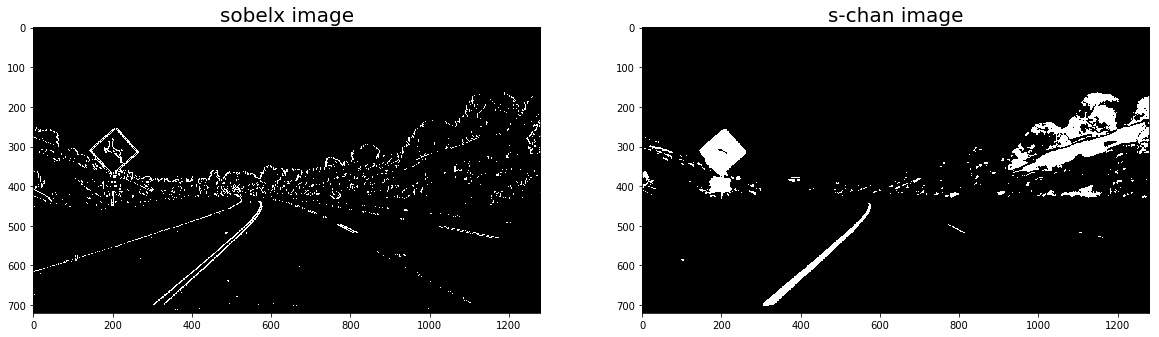

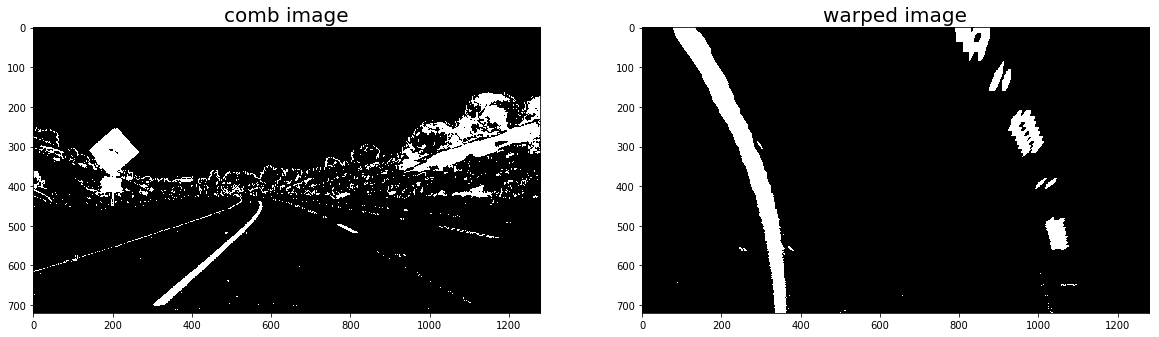

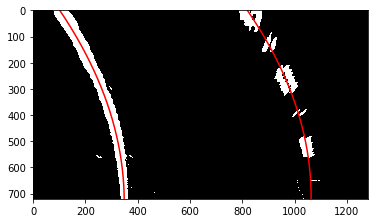

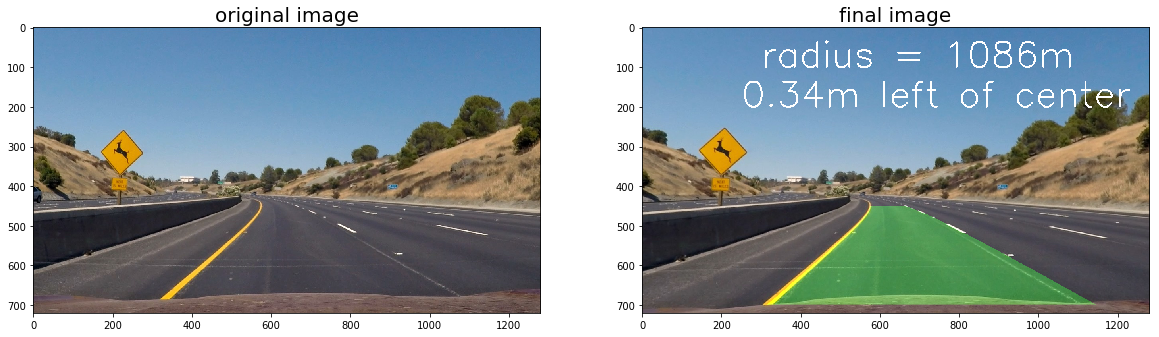

In [55]:
test_img = cv2.imread("test_images/test2.jpg")
# make sure using sliding search for single image
left.cont_bad = right.cont_bad = 0
left.fits = []
right.fits = []
from_video = 0

processed = pipeline(test_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
ax1.set_title('original image', fontsize = 20)
ax2.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
ax2.set_title('final image', fontsize = 20)


## Video Processing

In [58]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# initialize counter
left.cont_bad = right.cont_bad = 0
left.fits = []
right.fits = []
from_video = 1

clip1 = VideoFileClip("project_video.mp4")
#frames = clip1.iter_frames()
#print(sum(1 for frame in frames))
#plt.imshow(next(frames))
#total = 1
#for frame in frames:
    #if total < 5:
    #res = pipeline(frame)
    #cv2.imwrite("dbg/" + str(total) + ".jpg", cv2.cvtColor(res, cv2.COLOR_RGB2BGR))
    #total += 1
#print(total)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile("project_video_output.mp4", audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 14%|█▎        | 171/1261 [00:19<02:16,  7.96it/s]


 26%|██▌       | 323/1261 [00:37<01:54,  8.21it/s]


 38%|███▊      | 474/1261 [00:56<01:36,  8.19it/s]


 50%|████▉     | 626/1261 [01:14<01:14,  8.56it/s]


 62%|██████▏   | 778/1261 [01:32<00:59,  8.06it/s]


 74%|███████▍  | 930/1261 [01:51<00:40,  8.27it/s]


 86%|████████▌ | 1080/1261 [02:10<00:24,  7.51it/s]


 97%|█████████▋| 1228/1261 [02:28<00:04,  7.89it/s]


100%|█████████▉| 1260/1261 [02:32<00:00,  8.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 14s, sys: 2.96 s, total: 4min 17s
Wall time: 2min 34s


In [218]:
HTML("""
<video width="960" height="540" controls>
  <source src="project_video_output.mp4">
</video>
""")